<a href="https://colab.research.google.com/github/AndreuUtkin/ML_notebooks/blob/main/CNN_1d_Pozv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Чтение Excel файла
df = pd.read_excel('data.xlsx')

df

,BMI,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7),"грудн - 0, поясн -1",грудопоясн-0 поясн-1,тип повреждения по АО (A-0 B2-1),степень повреждения тела по АО (A3-0 A4-1),Локальный кифоз гр до,высота тела п/3 до,высота тела с/3 до,высота тела з/3 до,...,"нестабильных уровней, кол-во",Многоуровневая да/нет,нестабильность 0 - нет 1 - крайн или част 2 - полная,Из них полная нестабильность (CG-2),Severity,Реоперация по поводу нестабильности,Операция из-за нестабильности + перелом конструкции,перелом металла,резорбция вокруг винтов,смежный уровень
0,35.153397,2,0,0,1.0,1,-24.0,8.9,7.0,20.9,...,0,0,0,0,0,0,0,0,0,1
1,30.846277,3,1,0,1.0,1,-3.0,16.0,8.3,21.2,...,0,0,0,0,0,0,0,0,0,1
2,NaN,0,0,0,1.0,0,-24.0,13.9,18.4,24.4,...,1,0,1,0,2,1,1,0,1,1
3,26.729927,2,0,0,1.0,1,-15.0,10.9,10.7,30.8,...,1,0,1,0,1,1,1,0,1,0
4,26.753213,3,1,0,0.0,1,-17.0,5.5,12.2,19.3,...,2,1,2,1,2,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,21.545091,2,0,0,1.0,1,-40.0,12.2,13.6,22.8,...,0,0,0,0,0,0,0,0,0,0
288,22.857143,3,1,0,1.0,1,0.0,17.9,18.9,21.1,...,2,1,1,0,1,1,1,1,1,0
289,19.312952,3,1,0,1.0,1,-19.0,12.3,10.3,20.6,...,0,0,0,0,0,0,0,0,0,0
290,14.692378,4,1,1,0.0,1,-3.0,20.7,14.3,23.7,...,1,0,1,0,0,0,0,0,1,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Удалим Nullы

In [ ]:
df=df.dropna()

In [ ]:
print(df.isnull().sum())

BMI                                                                0
уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)    0
грудн - 0, поясн -1                                                0
грудопоясн-0 поясн-1                                               0
тип повреждения по АО (A-0 B2-1)                                   0
                                                                  ..
Реоперация по поводу нестабильности                                0
Операция из-за нестабильности + перелом конструкции                0
перелом металла                                                    0
резорбция вокруг винтов                                            0
смежный уровень                                                    0
Length: 72, dtype: int64


Преобразуем категориальные признаки

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Указываем колонки для кодирования
categorical_columns = [
    'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)',
    'повреждение суставов 0 -нет 1 - одностороннее 2 - двустороннее',
    'повреждение ножек 0 -нет 1 - одностороннее 2 - двустороннее',
    'Декомпрессия прямая 1-передняя 2-задняя 3-1+2 4-нет 5-задняя циркулярная',
    'группы по сегментам (1-моно 2-би 3-поли)',
    'межтеловой спондилодез 0- нет 1 - mesh 2 - кейдж 3 - крошка 4 - протез тела при 1-й операции',

    'нестабильность 0 - нет 1 - крайн или част 2 - полная'
]

from sklearn.compose import make_column_transformer

# Более простой способ без префиксов
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), categorical_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

df_encoded_array = preprocessor.fit_transform(df)
feature_names = preprocessor.get_feature_names_out()
df_encoded = pd.DataFrame(df_encoded_array, columns=feature_names)

print("Новые колонки:")
print(df_encoded.columns.tolist()[:100])

Новые колонки:
['уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_1', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_2', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_3', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_4', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_5', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_6', 'уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_7', 'повреждение суставов 0 -нет 1 - одностороннее 2 - двустороннее_1.0', 'повреждение суставов 0 -нет 1 - одностороннее 2 - двустороннее_2.0', 'повреждение ножек 0 -нет 1 - одностороннее 2 - двустороннее_1.0', 'повреждение ножек 0 -нет 1 - одностороннее 2 - двустороннее_2.0', 'Декомпрессия прямая 1-передняя 2-задняя 3-1+2 4-нет 5-задняя циркулярная_1', 'Декомпрессия прямая 1-передняя 2-задняя 3-1+2 4-нет 5-задняя циркулярная_2', 'Декомпрессия прямая 1-передняя 2-задняя 3-1+2 4-нет 5-задняя циркулярн

In [ ]:
df_encoded

,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_1,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_2,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_3,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_4,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_5,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_6,уровень стеноза (Th10-0 Th11-1 Th12-2 L1-3 L2-4 L3-5 L4-6 L5-7)_7,повреждение суставов 0 -нет 1 - одностороннее 2 - двустороннее_1.0,повреждение суставов 0 -нет 1 - одностороннее 2 - двустороннее_2.0,повреждение ножек 0 -нет 1 - одностороннее 2 - двустороннее_1.0,...,нестабильность винтов да/нет,"нестабильных уровней, кол-во",Многоуровневая да/нет,Из них полная нестабильность (CG-2),Severity,Реоперация по поводу нестабильности,Операция из-за нестабильности + перелом конструкции,перелом металла,резорбция вокруг винтов,смежный уровень
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0
186,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0
187,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Обучим модель для 2 признаков

In [ ]:
target_columns=[

    'Реоперация по поводу нестабильности',
    'Операция из-за нестабильности + перелом конструкции'
]

In [ ]:
feature_columns = [col for col in df_encoded.columns if col not in target_columns]

X = df_encoded[feature_columns]
y = df_encoded[target_columns]

print(f"Признаков: {X.shape[1]}")
print(f"Целевых переменных: {y.shape[1]}")

Признаков: 87
Целевых переменных: 2


In [ ]:
df = df.dropna()

# Проверка на наличие NaN после удаления
print(df.isnull().sum().sum())

0


In [ ]:
existing_categorical = [col for col in categorical_columns if col in X.columns]
X_encoded = pd.get_dummies(X, columns=existing_categorical, drop_first=True)

In [ ]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [ ]:
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

print(f"Форма данных для CNN: {X_cnn.shape}")

Форма данных для CNN: (190, 87, 1)


In [ ]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y.values, test_size=0.2, random_state=42
)

NameError: name 'train_test_split' is not defined

In [ ]:
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (152, 87, 1), Test: (38, 87, 1)


In [ ]:
def create_model(input_shape):
    model = Sequential([

        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(2, activation='sigmoid')
    ])

    return model

In [ ]:
input_shape = (X_train.shape[1], 1)
cnn_model = create_model(input_shape)

NameError: name 'X_train' is not defined

In [ ]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 83, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 39, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 39, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,234 (653.26 KB)

 Trainable params: 166,082 (648.76 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2799 - loss: 0.6741 - val_accuracy: 0.5789 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3622 - loss: 0.5363 - val_accuracy: 0.7895 - val_loss: 0.3896 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3755 - loss: 0.5068 - val_accuracy: 0.9211 - val_loss: 0.3202 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3375 - loss: 0.4100 - val_accuracy: 0.9211 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4175 - loss: 0.3696 - val_accuracy: 0.9211 - val_loss: 0.3816 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3929 - loss: 0.3102 - val_accuracy: 0.9474 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4295 - loss: 0.2845 - 

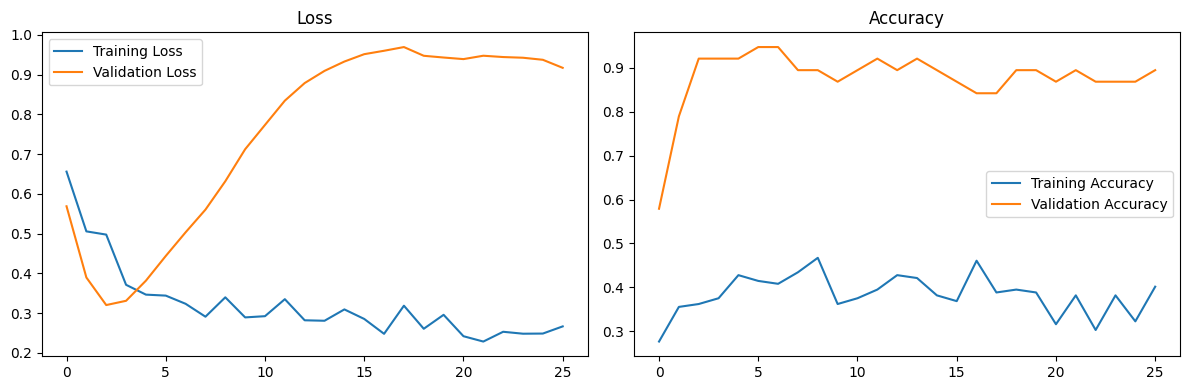

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
results = cnn_model.evaluate(X_train, y_train, verbose=0)


print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")

Loss: 0.4866
Accuracy: 0.9276


#10 признаков

In [ ]:
target_columns=[
    'нестабильность винтов да/нет',
       'нестабильность 0 - нет 1 - крайн или част 2 - полная_2',
'нестабильность 0 - нет 1 - крайн или част 2 - полная_1',

    'Из них полная нестабильность (CG-2)',
    'Реоперация по поводу нестабильности',
    'Операция из-за нестабильности + перелом конструкции',
    'перелом металла',
    'резорбция вокруг винтов',
    'смежный уровень',
    'Severity'
]

In [ ]:
feature_columns = [col for col in df_encoded.columns if col not in target_columns]

X = df_encoded[feature_columns]
y = df_encoded[target_columns]

print(f"Признаков: {X.shape[1]}")
print(f"Целевых переменных: {y.shape[1]}")

Признаков: 79
Целевых переменных: 10


In [ ]:
existing_categorical = [col for col in categorical_columns if col in X.columns]
X_encoded = pd.get_dummies(X, columns=existing_categorical, drop_first=True)

In [ ]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [ ]:
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

print(f"Форма данных для CNN: {X_cnn.shape}")

Форма данных для CNN: (190, 79, 1)


In [ ]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y.values, test_size=0.2, random_state=42
)

In [ ]:
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (152, 79, 1), Test: (38, 79, 1)


In [ ]:
def create_1d_cnn_model(input_shape):
    model = Sequential([

        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(10, activation='sigmoid')
    ])

    return model

In [ ]:
input_shape = (X_train.shape[1], 1)
cnn_model = create_1d_cnn_model(input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_39 (Conv1D)              │ (None, 75, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 75, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 35, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 35, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 15, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 15, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_13         │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,754 (655.29 KB)

 Trainable params: 166,602 (650.79 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0600 - loss: 0.8578 - val_accuracy: 0.0263 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0976 - loss: 0.6921 - val_accuracy: 0.0263 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0879 - loss: 0.6192 - val_accuracy: 0.6842 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0457 - loss: 0.4956 - val_accuracy: 0.5526 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0687 - loss: 0.4584 - val_accuracy: 0.4211 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1227 - loss: 0.3814 - val_accuracy: 0.4737 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1521 - loss: 0.3786 - 

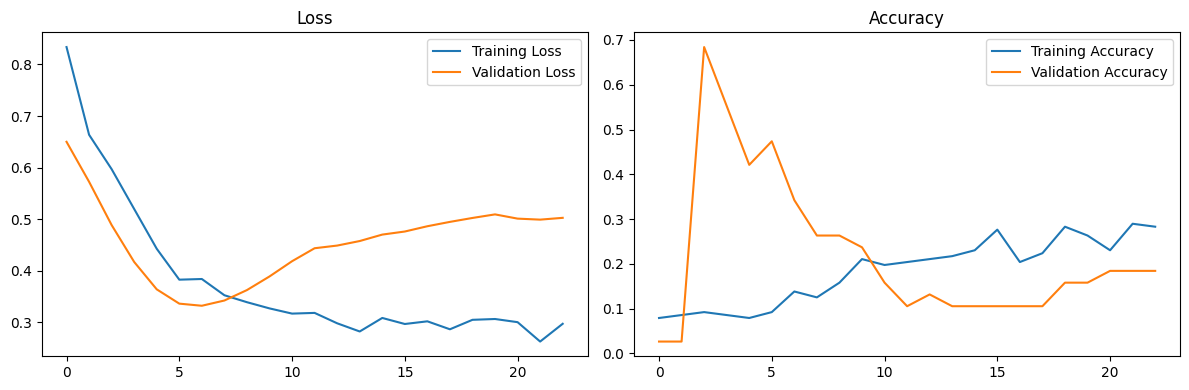

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
results = cnn_model.evaluate(X_train, y_train, verbose=0)


print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")

Loss: 0.4875
Accuracy: 0.6908


In [ ]:
# Предсказания
y_pred_nn = cnn_model.predict(X_test)
y_pred_binary_nn = (y_pred_nn > 0.5).astype(int)

# Оценка для каждого осложнения
complication_names = y.columns

print("\nТочность нейросети по каждому осложнению:")
nn_accuracies = {}
for i, complication in enumerate(complication_names):
    accuracy = np.mean(y_test[:, i] == y_pred_binary_nn[:, i])
    nn_accuracies[complication] = accuracy
    print(f"{complication}: {accuracy:.3f}")

# Общая точность
total_accuracy_nn = np.mean(y_test == y_pred_binary_nn)
print(f"\nСредняя точность для признаков: {total_accuracy_nn:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

Точность нейросети по каждому осложнению:
нестабильность винтов да/нет: 0.763
нестабильность 0 - нет 1 - крайн или част 2 - полная_2: 0.947
нестабильность 0 - нет 1 - крайн или част 2 - полная_1: 0.816
Из них полная нестабильность (CG-2): 0.921
Реоперация по поводу нестабильности: 0.921
Операция из-за нестабильности + перелом конструкции: 0.868
перелом металла: 1.000
резорбция вокруг винтов: 0.711
смежный уровень: 1.000
Severity: 0.868

Средняя точность для признаков: 0.882


In [ ]:
def check_columns_accuracy(model, X_test, y_test):

    # Предсказания
    y_pred = model.predict(X_test, verbose=0)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Считаем правильные предсказания по столбцам
    n_patients = y_test.shape[0]
    n_columns = y_test.shape[1]

    # Среднее количество правильных столбцов на пациента
    correct_per_patient = np.sum(y_test == y_pred_binary, axis=1)
    avg_correct = np.mean(correct_per_patient)

    # Процент
    percentage = (avg_correct / n_columns) * 100

    return f"{avg_correct:.1f}/{n_columns} ({percentage:.1f}%)"

# ПРИМЕР ИСПОЛЬЗОВАНИЯ:
result = check_columns_accuracy(cnn_model, X_test, y_test)
print(f"угадывает в среднем: {result}")

угадывает в среднем: 8.8/10 (88.2%)
